In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
from sctriangulate.colors import build_custom_continuous_cmap
import imageio
import os
%matplotlib inline

# functions

In [13]:
# returns best output for a length 1-2 route swap
def get_best_route_output(ind_a, ind_b, input_a, pair_reserve_dict):
    best_output = 0
    if ind_b in pair_reserve_dict[ind_a]:
        reserve_a, reserve_b = pair_reserve_dict[ind_b][ind_a], pair_reserve_dict[ind_a][ind_b]
        best_output = input_a * reserve_b / (reserve_a + input_a)
    for key,value in pair_reserve_dict[ind_a].items():
        reserve_a, reserve_z = pair_reserve_dict[key][ind_a], value
        input_z = input_a * reserve_z / (reserve_a + input_a)
        if key in pair_reserve_dict[ind_b] and ind_b in pair_reserve_dict[key]:
            reserve_z, rezerve_b = pair_reserve_dict[ind_b][key], pair_reserve_dict[key][ind_b]
            potential_output = input_z * rezerve_b / (rezerve_b + input_z + 1) # to prevent possible zero division
            if potential_output > best_output:
                best_output = potential_output
    return best_output

def get_data(dex_data, coin_data, top_chain_tokens, chain_symbols):
    erc20_pairs = pd.read_csv(dex_data, header=None)
    erc20_pairs[2] = erc20_pairs[2].str.lower()
    erc20_pairs[3] = erc20_pairs[3].str.lower()
    erc20_pairs = erc20_pairs.values.tolist()
    coin_pairs = pd.read_csv(coin_data, header=None)
    coin_pairs[1] = coin_pairs[1].str.lower()
    coin_pairs = coin_pairs.values.tolist()
    with open(top_chain_tokens, 'r') as fil:
        tokens = [elm.lower() for elm in fil.read().split('\n')]
    token_to_ind = dict(zip(tokens,list(range(len(tokens)))))
    symbols = [elm[1] for elm in pd.read_csv(chain_symbols, header=None).values.tolist()]
    return erc20_pairs, coin_pairs, tokens, token_to_ind, symbols

def prepare_data(tokens, erc20_pairs, chain_symbols, token_to_ind):
    sparse_matrix = np.zeros([len(tokens), len(tokens)])
    ind_to_symbol = {}
    for pair in erc20_pairs:
        token0, token1 = pair[2], pair[3]
        ind0 = token_to_ind[token0]
        ind1 = token_to_ind[token1]
        sparse_matrix[ind0, ind1] = 1
        sparse_matrix[ind1, ind0] = 1
    sparse_df = pd.DataFrame(sparse_matrix)
    sparse_df.columns = chain_symbols
    sparse_df.index = chain_symbols
    return sparse_df

def get_reserves(coin_pairs, token_to_ind, erc20_pairs, WETH):
    pair_reserve_dict = {'eth': {}} 
    pool_reserves = {}
    for i in coin_pairs:
        token = token_to_ind[i[1]]
        pair_reserve_dict['eth'][token] = int(i[2])
        if token not in pair_reserve_dict:
            pair_reserve_dict[token] = {}
        pair_reserve_dict[token]['eth'] = int(i[0])
        pool_reserves[token] = int(i[2])
    for i in erc20_pairs:
        ind0, ind1 = token_to_ind[i[2]], token_to_ind[i[3]]
        reserve0, reserve1 = int(i[4]), int(i[5])
        pair_reserve_dict[ind0][ind1] = reserve1
        pair_reserve_dict[ind1][ind0] = reserve0
        if i[2] != WETH:
            pool_reserves[ind0] += reserve0
        if i[3] != WETH:
            pool_reserves[ind1] += reserve1
    return pair_reserve_dict, pool_reserves

def get_token_combinations(dex_tokens, token_to_ind):
    all_token_combinations = []
    for i in dex_tokens:
        for j in dex_tokens:
            ind0, ind1 = token_to_ind[i], token_to_ind[j]
            if ind0 != ind1:
                all_token_combinations.append([ind0, ind1])
    return all_token_combinations

def get_xfai_simulation(token_to_ind, coin_pairs, pool_reserves):
    xfai_pool_sim = {token_to_ind[elm[1]]:{'r': int(elm[2]), 'w':int(elm[0])} for elm in coin_pairs}
    xfai_pool_sim = {key:{'r': pool_reserves[key], 'w': pool_reserves[key] * value['w'] / value['r']} for key, value in xfai_pool_sim.items()}
    return xfai_pool_sim

def get_performance_matrices_normalized(all_token_combinations, xfai_pool_sim, pair_reserve_dict, coin_symbols):
    xfai_matrix, dex_matrix = np.zeros([100,100]), np.zeros([100,100])
    for i in all_token_combinations:
        ind0, ind1 = i[0],i[1]
        xfai_pool0, xfai_pool1 = xfai_pool_sim[ind0], xfai_pool_sim[ind1]
        input_amount0, input_amount1 = xfai_pool0['r'], xfai_pool1['r']
        xfai_output0 = (input_amount0 * xfai_pool0['w'] / (input_amount0 + xfai_pool0['r'])) * xfai_pool1['r'] / (xfai_pool1['w'] + (input_amount0 * xfai_pool0['w'] / (input_amount0 + xfai_pool0['r'])))
        xfai_output1 = (input_amount1 * xfai_pool1['w'] / (input_amount1 + xfai_pool1['r'])) * xfai_pool0['r'] / (xfai_pool0['w'] + (input_amount1 * xfai_pool1['w'] / (input_amount1 + xfai_pool1['r'])))
        dex_output0 = get_best_route_output(ind0, ind1, input_amount0, pair_reserve_dict)
        dex_output1 = get_best_route_output(ind1, ind0, input_amount1, pair_reserve_dict)
        xfai_deviation0, xfai_deviation1 = xfai_output0 / (dex_output0+xfai_output0), xfai_output1 / (dex_output1+xfai_output1)
        dex_deviation0, dex_deviation1 = dex_output0 / (dex_output0+xfai_output0), dex_output1 / (dex_output1+xfai_output1)
        xfai_matrix[ind0, ind1] = xfai_deviation0
        xfai_matrix[ind1, ind0] = xfai_deviation1
        dex_matrix[ind0,ind1] = dex_deviation0
        dex_matrix[ind1,ind0] = dex_deviation1
    xfai_df = pd.DataFrame(xfai_matrix)
    xfai_df.columns = coin_symbols
    xfai_df.index = coin_symbols
    dex_df = pd.DataFrame(dex_matrix)
    dex_df.columns = coin_symbols
    dex_df.index = coin_symbols
    return xfai_df, dex_df

def get_performance_gradient_matrices_normalized(all_token_combinations, xfai_pool_sim, pair_reserve_dict, coin_symbols, percentage):
    xfai_matrix, dex_matrix = np.zeros([100,100]), np.zeros([100,100])
    for i in all_token_combinations:
        ind0, ind1 = i[0],i[1]
        xfai_pool0, xfai_pool1 = xfai_pool_sim[ind0], xfai_pool_sim[ind1]
        input_amount0, input_amount1 = xfai_pool0['r'], xfai_pool1['r']
        perc_r0, perc_r1 = xfai_pool0['r'] * percentage, xfai_pool1['r'] * percentage
        xfai_output0 = (input_amount0 * xfai_pool0['w'] / (input_amount0 + perc_r0)) * perc_r1 / (xfai_pool1['w'] + (input_amount0 * xfai_pool0['w'] / (input_amount0 + perc_r0)))
        xfai_output1 = (input_amount1 * xfai_pool1['w'] / (input_amount1 + perc_r1)) * perc_r0 / (xfai_pool0['w'] + (input_amount1 * xfai_pool1['w'] / (input_amount1 + perc_r1)))
        dex_output0 = get_best_route_output(ind0, ind1, input_amount0, pair_reserve_dict)
        dex_output1 = get_best_route_output(ind1, ind0, input_amount1, pair_reserve_dict)
        xfai_deviation0, xfai_deviation1 = xfai_output0 / (dex_output0+xfai_output0), xfai_output1 / (dex_output1+xfai_output1)
        dex_deviation0, dex_deviation1 = dex_output0 / (dex_output0+xfai_output0), dex_output1 / (dex_output1+xfai_output1)
        xfai_matrix[ind0, ind1] = xfai_deviation0
        xfai_matrix[ind1, ind0] = xfai_deviation1
        dex_matrix[ind0,ind1] = dex_deviation0
        dex_matrix[ind1,ind0] = dex_deviation1
    xfai_df = pd.DataFrame(xfai_matrix)
    xfai_df.columns = coin_symbols
    xfai_df.index = coin_symbols
    dex_df = pd.DataFrame(dex_matrix)
    dex_df.columns = coin_symbols
    dex_df.index = coin_symbols
    return xfai_df, dex_df


# Compute states 

In [14]:
uni = 'datasets/final/univ2_2022_11_25/erc20_to_erc20.csv'
uni_weth = 'datasets/final/univ2_2022_11_25/weth_to_erc20.csv'
ethereum = 'datasets/tokens/ethereum/top_100_26_11_2022.csv'
eth_symbols = 'datasets/tokens/ethereum/symbols.csv'
WETH = '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2'

pancake = 'datasets/final/pancake_2022_11_25/erc20_to_erc20.csv'
pancake_wbnb = 'datasets/final/pancake_2022_11_25/weth_to_erc20.csv'
binance = 'datasets/tokens/binance/top_100_26_11_2022.csv'
bsc_symbols = 'datasets/tokens/binance/symbols.csv'
WBNB = '0xbb4cdb9cbd36b01bd1cbaebf2de08d9173bc095c'

percentages = [elm/100 for elm in range(1,11)] + [elm/10 for elm in range(1,11)]

ethereum_erc20_pairs, eth_pairs, uni_tokens, ethereum_token_to_ind, eth_symbols = get_data(uni, uni_weth, ethereum, eth_symbols)
uni_sparse_df = prepare_data(uni_tokens, ethereum_erc20_pairs, eth_symbols, ethereum_token_to_ind)
eth_pair_reserve_dict, eth_pool_reserves = get_reserves(eth_pairs, ethereum_token_to_ind, ethereum_erc20_pairs, WETH)
eth_all_token_combinations = get_token_combinations(uni_tokens, ethereum_token_to_ind)
eth_xfai_pool_sim = get_xfai_simulation(ethereum_token_to_ind, eth_pairs, eth_pool_reserves)
ethereum_xfai_df, uni_df = get_performance_matrices_normalized(eth_all_token_combinations, eth_xfai_pool_sim, eth_pair_reserve_dict, eth_symbols)
eth_liquidity_change = [get_performance_gradient_matrices_normalized(eth_all_token_combinations, eth_xfai_pool_sim, eth_pair_reserve_dict, eth_symbols, elm) for elm in percentages]

binance_erc20_pairs, bsc_pairs, pancake_tokens, binance_token_to_ind, bsc_symbols = get_data(pancake, pancake_wbnb, binance, bsc_symbols)
pancake_sparse_df = prepare_data(pancake_tokens, binance_erc20_pairs, bsc_symbols, binance_token_to_ind)
bsc_pair_reserve_dict, bsc_pool_reserves = get_reserves(bsc_pairs, binance_token_to_ind, binance_erc20_pairs, WBNB)
bsc_all_token_combinations = get_token_combinations(pancake_tokens, binance_token_to_ind)
bsc_xfai_pool_sim = get_xfai_simulation(binance_token_to_ind, bsc_pairs, bsc_pool_reserves)
binance_xfai_df, pancake_df = get_performance_matrices_normalized(bsc_all_token_combinations, bsc_xfai_pool_sim, bsc_pair_reserve_dict, bsc_symbols)
binance_liquidity_change = [get_performance_gradient_matrices_normalized(bsc_all_token_combinations, bsc_xfai_pool_sim, bsc_pair_reserve_dict, bsc_symbols, elm) for elm in percentages]


## Plot the token pair binary heat map of the top 100 tokens present on Uniswap V2

Text(0.5, 1.0, 'The token pairs of the top 100 tokens on Pancakeswap V2')

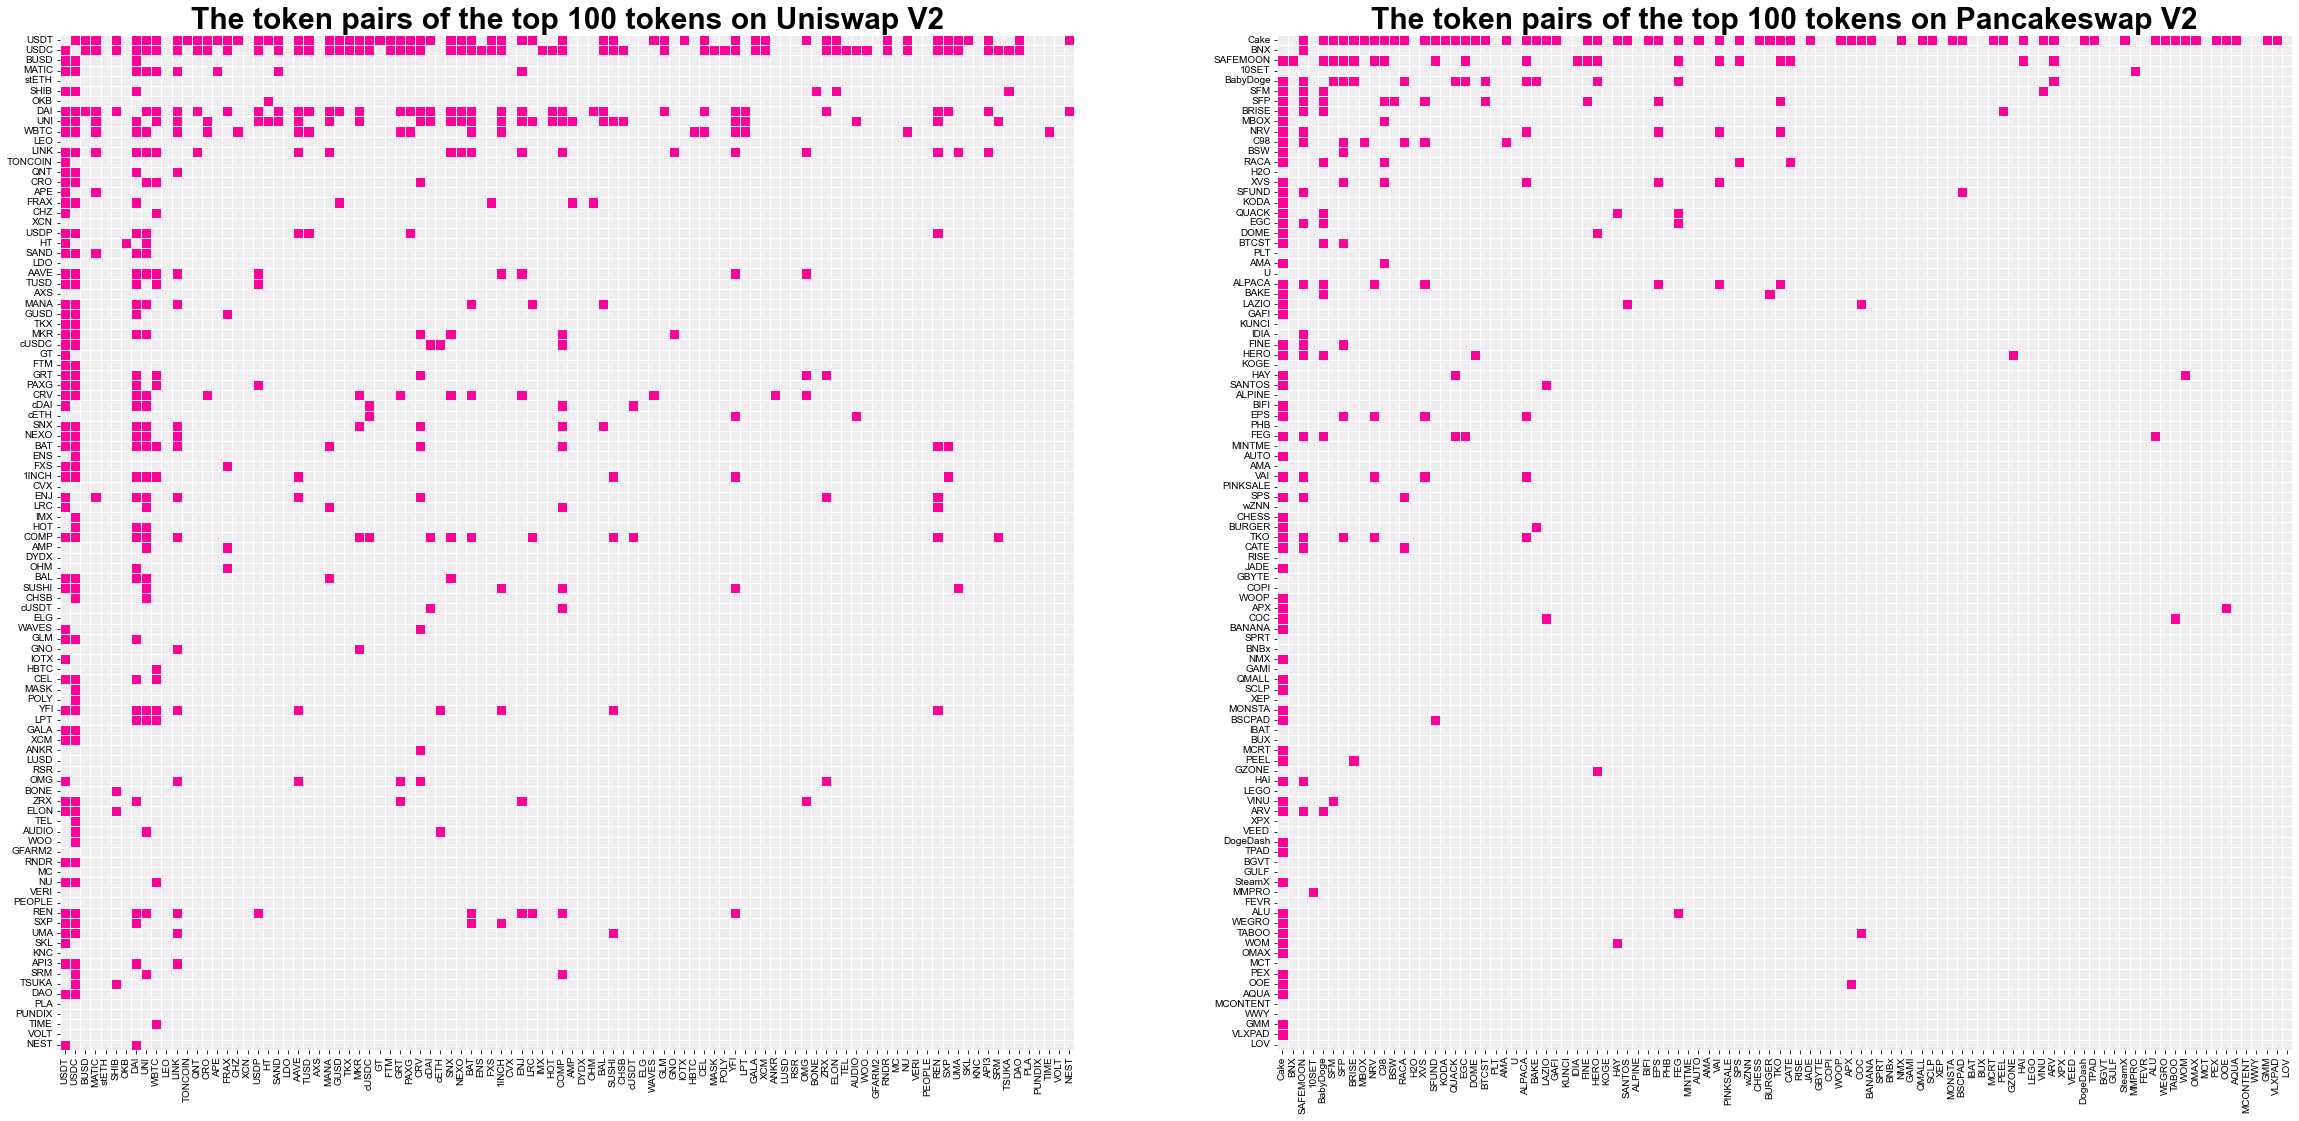

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(40, 20))
cmap0 = colors.ListedColormap(['#EFECF0','#FF0098'])
cmap1 = colors.ListedColormap(['#EFECF0','#FF0098'])
im0 = sns.heatmap(uni_sparse_df, 
                  ax=ax[0], 
                  xticklabels=True,
                  yticklabels=True,
                  linewidth=1, 
                  linecolor='w', 
                  square=True, 
                  cbar=False, 
                  cmap = cmap0
                 )
ax[0].set_title("The token pairs of the top 100 tokens on Uniswap V2", size=30, fontweight='bold')

im1 = sns.heatmap(pancake_sparse_df, 
                  ax=ax[1], 
                  xticklabels=True,
                  yticklabels=True,
                  linewidth=1, 
                  linecolor='w', 
                  square=True, 
                  cbar=False, 
                  cmap = cmap1
                 )
ax[1].set_title("The token pairs of the top 100 tokens on Pancakeswap V2", size=30, fontweight='bold')

#plt.savefig("token_pair_distribution.eps", bbox_inches='tight')

# Compute slippage performance

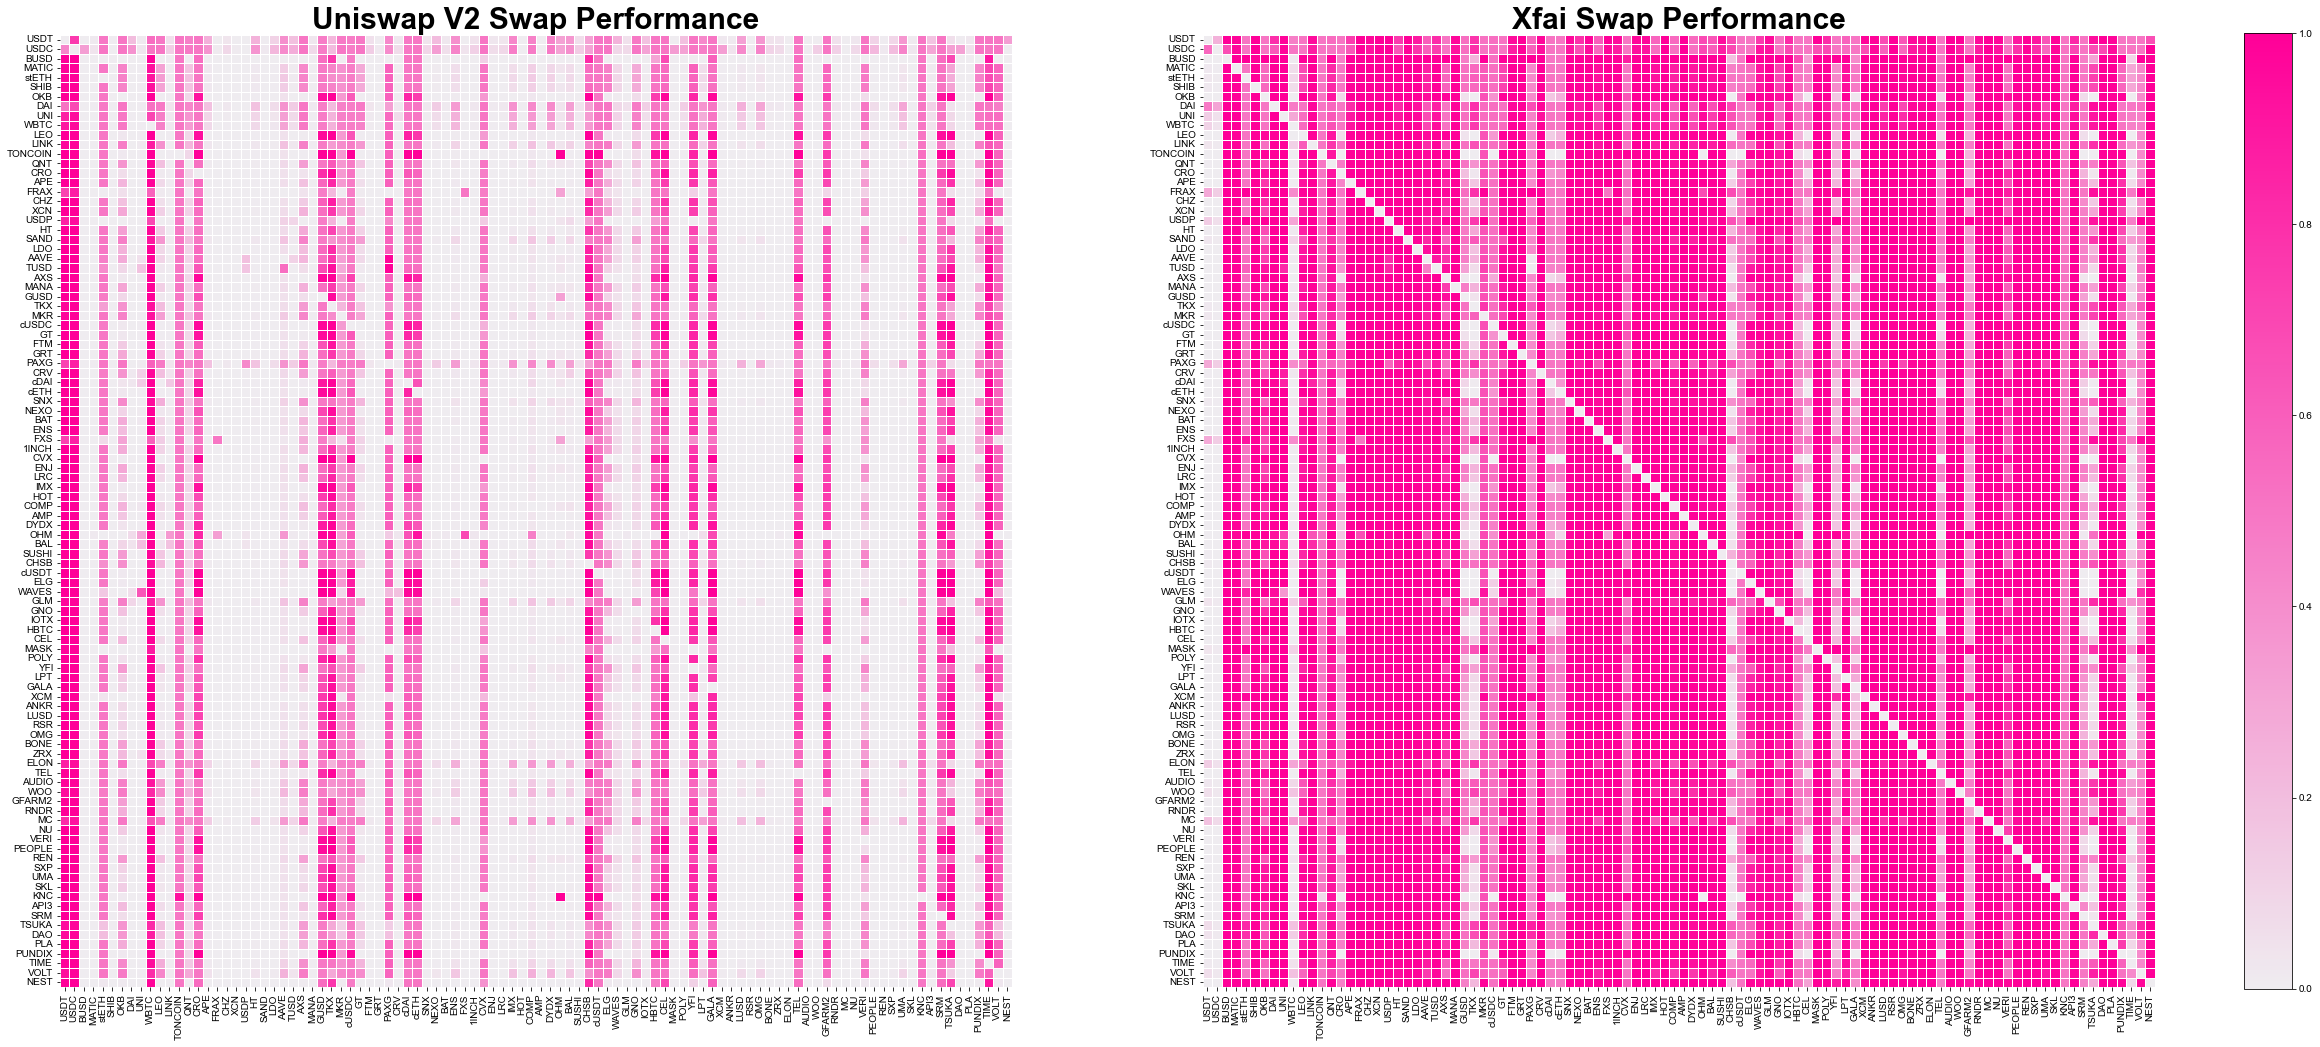

In [20]:
cmap = build_custom_continuous_cmap([239,236,240], [255,0,152])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(40, 20))


im0 = sns.heatmap(uni_df, 
                  ax=ax[0], 
                  xticklabels=True,
                  yticklabels=True,
                  linewidth=1, 
                  linecolor='w', 
                  square=True, 
                  cbar=False, 
                  cmap = cmap,
                 )
ax[0].set_title("Uniswap V2 Swap Performance", size=30, fontweight='bold')

im1 = sns.heatmap(ethereum_xfai_df, 
                  ax=ax[1], 
                  xticklabels=True,
                  yticklabels=True,
                  linewidth=1, 
                  linecolor='w', 
                  square=True, 
                  cbar=False, 
                  cmap = cmap,
                 )
ax[1].set_title("Xfai Swap Performance", size=30, fontweight='bold')

cb = im1.get_children()[0]
plt.colorbar(cb, ax = [ax[0],ax[1]],orientation = 'vertical', fraction=0.0214, pad=0.04)

plt.savefig("xfai_uni_performance_heatmaps.eps", bbox_inches='tight')

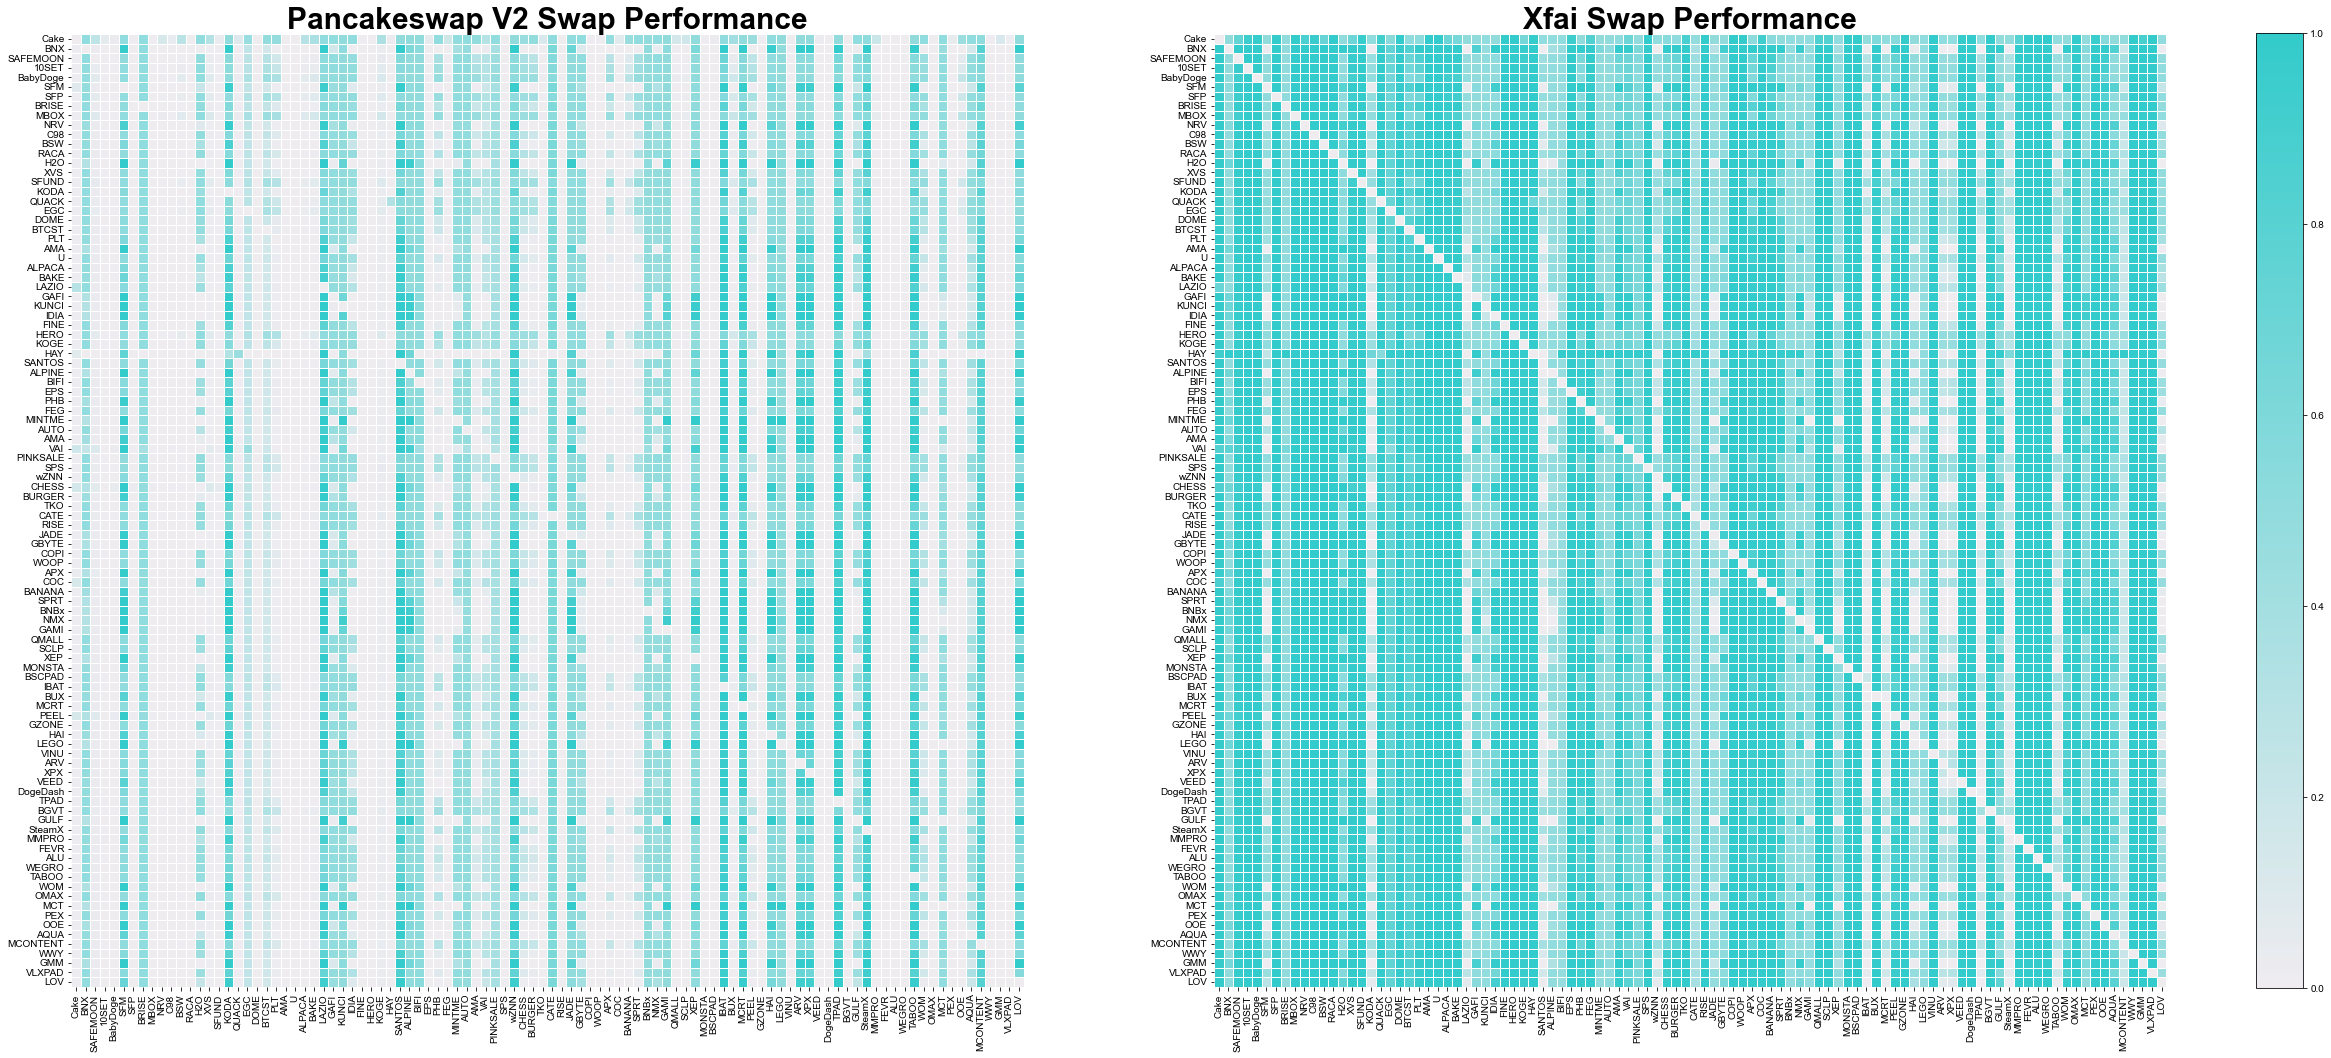

In [21]:
cmap = build_custom_continuous_cmap([239,236,240], [51,203,203])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(40, 20))


im0 = sns.heatmap(pancake_df, 
                  ax=ax[0], 
                  xticklabels=True,
                  yticklabels=True,
                  linewidth=1, 
                  linecolor='w', 
                  square=True, 
                  cbar=False, 
                  cmap = cmap,
                 )
ax[0].set_title("Pancakeswap V2 Swap Performance", size=30, fontweight='bold')

im1 = sns.heatmap(binance_xfai_df, 
                  ax=ax[1], 
                  xticklabels=True,
                  yticklabels=True,
                  linewidth=1, 
                  linecolor='w', 
                  square=True, 
                  cbar=False, 
                  cmap = cmap,
                 )
ax[1].set_title("Xfai Swap Performance", size=30, fontweight='bold')

cb = im1.get_children()[0]
plt.colorbar(cb, ax = [ax[0],ax[1]],orientation = 'vertical', fraction=0.0214, pad=0.04)

plt.savefig("xfai_pencake_performance_heatmaps.eps", bbox_inches='tight')

# basic statistics for internal use / pitch decks

In [18]:
def above_threshold(matrix, threshold):
    positive_cases = (matrix.to_numpy() >= threshold).sum() - 100
    return positive_cases / (matrix.shape[0] * matrix.shape[1] - 100)

uni = str(((100 / (100*above_threshold(uni_df, 0.5))) - 1).round(2))
uni_xfai = str((above_threshold(ethereum_xfai_df, 0.5) * 100).round(2))
pan = str(((100 / (100*above_threshold(pancake_df, 0.5))) - 1).round(2))
pan_xfai = str((above_threshold(binance_xfai_df, 0.5) * 100).round(2))
print('\nAssuming an Xfai simulation with the same amounts of locked liquidity as Uni V2,\nXfai would be chosen '+uni+'% times more often than Uni V2 by DEX aggregators.') 
print('If we look at how many of the possible trades Xfai outperforms Uni V2, we get a rate of '+ uni_xfai +'%.')
print('\nAssuming an Xfai simulation with the same amounts of locked liquidity as Pancakeswap,\nXfai would be chosen '+pan+'% times more often than Pancakeswap by DEX aggregators.') 
print('If we look at how many of the possible trades Xfai outperforms Pancakeswap, we get a rate of '+pan_xfai +'%.')


Assuming an Xfai simulation with the same amounts of locked liquidity as Uni V2,
Xfai would be chosen 4.26% times more often than Uni V2 by DEX aggregators.
If we look at how many of the possible trades Xfai outperforms Uni V2, we get a rate of 78.98%.

Assuming an Xfai simulation with the same amounts of locked liquidity as Pancakeswap,
Xfai would be chosen 3.43% times more often than Pancakeswap by DEX aggregators.
If we look at how many of the possible trades Xfai outperforms Pancakeswap, we get a rate of 75.42%.


In [19]:
eth_times = [((100 / (100*above_threshold(elm[1], 0.5))) - 1).round(2) for elm in eth_liquidity_change]
eth_rate = [(above_threshold(elm[0], 0.5) * 100).round(2) for elm in eth_liquidity_change]
print(percentages)
print(eth_times)
print(eth_rate)

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
[1.35, 1.52, 1.64, 1.74, 1.81, 1.89, 1.94, 1.99, 2.04, 2.09, 2.09, 2.32, 2.45, 2.62, 2.76, 2.89, 2.96, 3.05, 3.25, 4.26]
[55.44, 58.35, 60.11, 61.53, 62.37, 63.37, 63.97, 64.57, 65.09, 65.58, 65.58, 67.86, 68.97, 70.32, 71.37, 72.25, 72.73, 73.3, 74.42, 78.98]


In [9]:
xfai_performances = ethereum_xfai_df.to_numpy()

average_performance = xfai_performances.sum() / (xfai_performances.shape[0] * xfai_performances.shape[1] - 100)
average_performance - (1 - average_performance)

0.6034586773141908

In [10]:
from scipy.stats import pareto

top_daily_volume = 12215432
x_m = 1 #scale
alpha = 7
samples = np.linspace(start=1, stop=5, num=100)
output = np.array([pareto.pdf(x=samples, b=alpha, loc=0, scale=x_m)])
daily_volume_distr = top_daily_volume * (output / output.max()).T

In [11]:
# lp apr
reserve = 312155178 / 2
daily_voume = top_daily_volume
fees = 0.02
perc_of_pool = 0.2
yearly_fees = daily_voume * fees * 365 * perc_of_pool
liquidity = reserve * perc_of_pool
yearly_fees / liquidity * 100

57.13354119020894

In [12]:
# infinity staker apr
number_of_pools = 100
perc_of_inft = 0.2
yearly_fees = float(sum(daily_volume_distr * fees * 365 * perc_of_inft))
yearly_fees / liquidity * 100

232.10733633996

# swap heat map as a function of total liquidity locked

(gif saved in /performenace_gifs)

In [18]:
def heatmap(liquidity_change, cmap, gif_dir, title, percentage, num):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(40, 20))
    im0 = sns.heatmap(liquidity_change[num][1], 
                      ax=ax[0], 
                      xticklabels=True,
                      yticklabels=True,
                      linewidth=1, 
                      linecolor='w', 
                      square=True, 
                      cbar=False, 
                      cmap = cmap,
                     )
    ax[0].set_title(title + " Swap Performance", size=30, fontweight='bold')
    im1 = sns.heatmap(liquidity_change[num][0], 
                      ax=ax[1], 
                      xticklabels=True,
                      yticklabels=True,
                      linewidth=1, 
                      linecolor='w', 
                      square=True, 
                      cbar=False, 
                      cmap = cmap,
                     )
    ax[1].set_title(f"Xfai Swap Performance with {percentage}% of {title}'s liquidity", size=30, fontweight='bold')

    cb = im1.get_children()[0]
    plt.colorbar(cb, ax = [ax[0],ax[1]],orientation = 'vertical', fraction=0.0214, pad=0.04)

    plt.savefig(f"{gif_dir}{title[:3]}_xfai_performance_{num}.png", bbox_inches='tight', transparent = False, facecolor = 'white')
    plt.close()

gif_dir = "performance_gifs/"
cmap_uni = build_custom_continuous_cmap([239,236,240], [255,0,152])
cmap_pan = build_custom_continuous_cmap([239,236,240], [51,203,203])

for i in range(len(eth_liquidity_change)):
    heatmap(eth_liquidity_change, cmap_uni, gif_dir, "Uni V2", percentages[i], i)
frames = [imageio.v2.imread(f'{gif_dir}/Uni_xfai_performance_{i}.png') for i in range(len(percentages))]
for file in os.listdir(gif_dir):
    if file.endswith('.png'):
        os.remove(f'{gif_dir}{file}') 
imageio.mimsave(f'{gif_dir}Uniswap_vs_xfai.gif', frames,fps = 2)


for i in range(len(binance_liquidity_change)):
    heatmap(eth_liquidity_change, cmap_pan, gif_dir, "Pancakeswap V2", percentages[i], i)
frames = [imageio.v2.imread(f'{gif_dir}/Pan_xfai_performance_{i}.png') for i in range(len(percentages))]
for file in os.listdir(gif_dir):
    if file.endswith('.png'):
        os.remove(f'{gif_dir}{file}') 
imageio.mimsave(f'{gif_dir}Pancakeswap_vs_xfai.gif', frames,fps = 2)  

# Other visualizations for internal usage

/var/folders/4m/yxhj0vrd6n94xtzttqhs1sp80000gn/T/ipykernel_65148/1727951253.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  a = ax[0,0].set_xticklabels(symbols, rotation=90)
/var/folders/4m/yxhj0vrd6n94xtzttqhs1sp80000gn/T/ipykernel_65148/1727951253.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  a = ax[0,1].set_xticklabels(symbols, rotation=90)
/var/folders/4m/yxhj0vrd6n94xtzttqhs1sp80000gn/T/ipykernel_65148/1727951253.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  a = ax[1,0].set_xticklabels(symbols, rotation=90)
/var/folders/4m/yxhj0vrd6n94xtzttqhs1sp80000gn/T/ipykernel_65148/1727951253.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  a = ax[1,1].set_xticklabels(symbols, rotation=90)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparenc

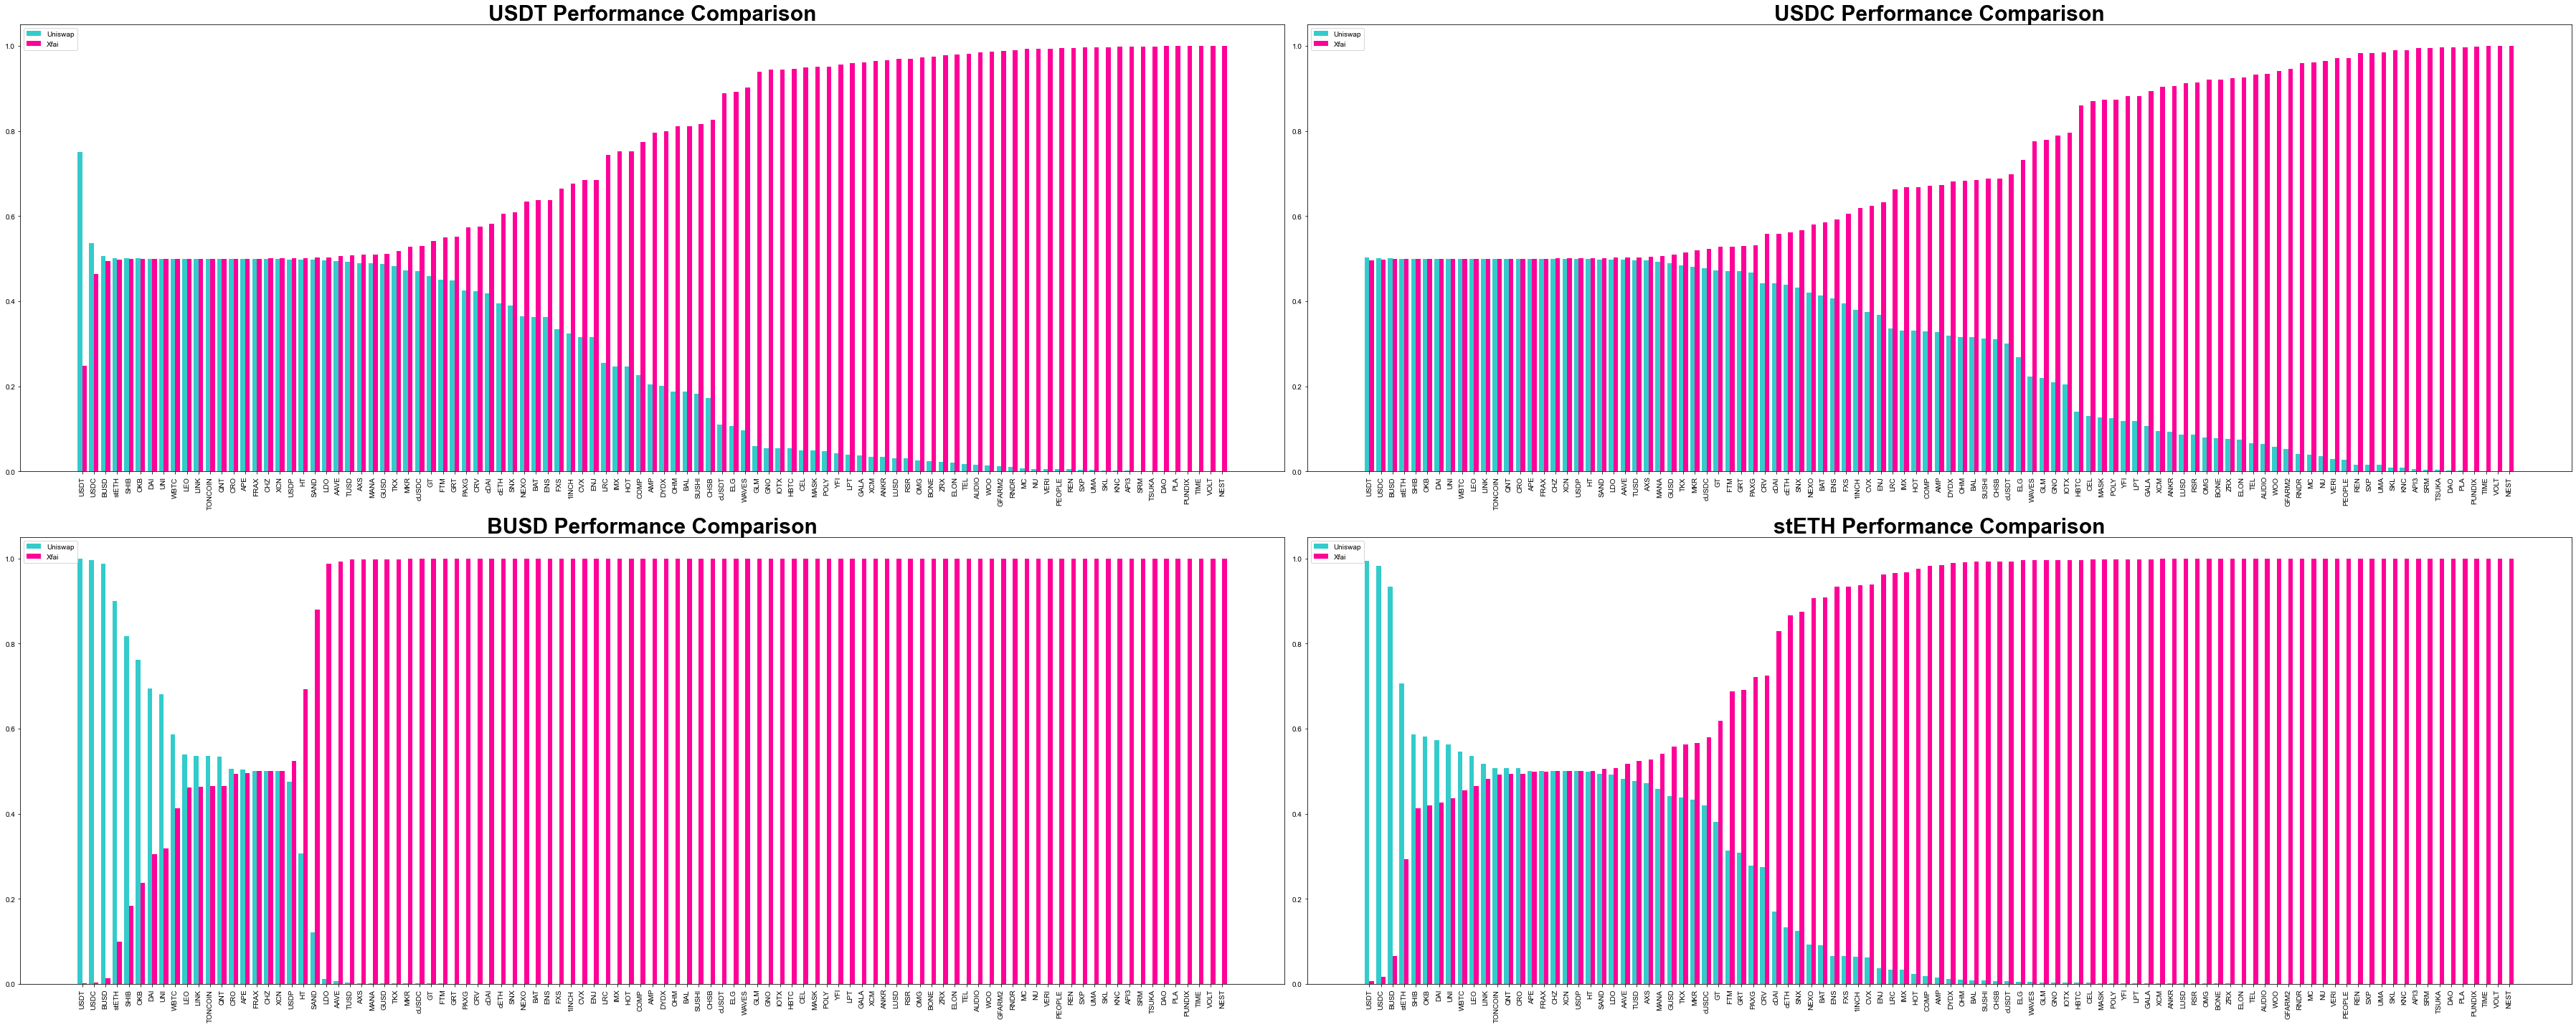

In [22]:
xfai_performances = []
uni_performances = []
for iteration in range(4):
    mask = np.ones(len(uni_df.columns)).astype(bool)
    mask[iteration] = 0
    symbols = uni_df.columns.to_numpy()[mask]
    uni_usdc_trades = uni_df.to_numpy()[iteration,:][mask]
    xfai_usdc_trades = ethereum_xfai_df.to_numpy()[iteration,:][mask]
    indices = uni_usdc_trades.argsort()[::-1]
    sorted_uni_usdc_trades = uni_usdc_trades[indices]
    sorted_xfai_usdc_trades = xfai_usdc_trades[indices]
    xfai_performances.append(sorted_xfai_usdc_trades)
    uni_performances.append(sorted_uni_usdc_trades)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(50, 20))

# usdt
ax[0,0].bar(symbols, uni_performances[0], label = 'Uniswap', align='edge', width=-0.4, color='#33CBCB')
ax[0,0].bar(symbols, xfai_performances[0], label = 'Xfai', align='edge', width=0.4, color='#FF0098')
a = ax[0,0].set_xticklabels(symbols, rotation=90)
ax[0,0].legend(loc = "upper left")
ax[0,0].set_title("USDT Performance Comparison", size=30, fontweight='bold')

# usdc
ax[0,1].bar(symbols, uni_performances[1], label = 'Uniswap', align='edge', width=-0.4, color='#33CBCB')
ax[0,1].bar(symbols, xfai_performances[1], label = 'Xfai', align='edge', width=0.4, color='#FF0098')
a = ax[0,1].set_xticklabels(symbols, rotation=90)
ax[0,1].legend(loc = "upper left")
ax[0,1].set_title("USDC Performance Comparison", size=30, fontweight='bold')

# busd
ax[1,0].bar(symbols, uni_performances[2], label = 'Uniswap', align='edge', width=-0.4, color='#33CBCB')
ax[1,0].bar(symbols, xfai_performances[2], label = 'Xfai', align='edge', width=0.4, color='#FF0098')
a = ax[1,0].set_xticklabels(symbols, rotation=90)
ax[1,0].legend(loc = "upper left")
ax[1,0].set_title("BUSD Performance Comparison", size=30, fontweight='bold')

# stETH
ax[1,1].bar(symbols, uni_performances[3], label = 'Uniswap', align='edge', width=-0.4, color='#33CBCB')
ax[1,1].bar(symbols, xfai_performances[3], label = 'Xfai', align='edge', width=0.4, color='#FF0098')
a = ax[1,1].set_xticklabels(symbols, rotation=90)
ax[1,1].legend(loc = "upper left")
ax[1,1].set_title("stETH Performance Comparison", size=30, fontweight='bold')

plt.tight_layout()

plt.savefig("top_4_comparison.eps", bbox_inches='tight')

In [159]:
symbols

array(['USDT', 'USDC', 'BUSD', 'stETH', 'SHIB', 'OKB', 'DAI', 'UNI',
       'WBTC', 'LEO', 'LINK', 'TONCOIN', 'QNT', 'CRO', 'APE', 'FRAX',
       'CHZ', 'XCN', 'USDP', 'HT', 'SAND', 'LDO', 'AAVE', 'TUSD', 'AXS',
       'MANA', 'GUSD', 'TKX', 'MKR', 'cUSDC', 'GT', 'FTM', 'GRT', 'PAXG',
       'CRV', 'cDAI', 'cETH', 'SNX', 'NEXO', 'BAT', 'ENS', 'FXS', '1INCH',
       'CVX', 'ENJ', 'LRC', 'IMX', 'HOT', 'COMP', 'AMP', 'DYDX', 'OHM',
       'BAL', 'SUSHI', 'CHSB', 'cUSDT', 'ELG', 'WAVES', 'GLM', 'GNO',
       'IOTX', 'HBTC', 'CEL', 'MASK', 'POLY', 'YFI', 'LPT', 'GALA', 'XCM',
       'ANKR', 'LUSD', 'RSR', 'OMG', 'BONE', 'ZRX', 'ELON', 'TEL',
       'AUDIO', 'WOO', 'GFARM2', 'RNDR', 'MC', 'NU', 'VERI', 'PEOPLE',
       'REN', 'SXP', 'UMA', 'SKL', 'KNC', 'API3', 'SRM', 'TSUKA', 'DAO',
       'PLA', 'PUNDIX', 'TIME', 'VOLT', 'NEST'], dtype=object)